In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls "/content/gdrive/My Drive/COVID-19 Dataset"


Mounted at /content/gdrive
CT  X-ray


In [51]:

#@markdown #**Anti-Disconnect for Google Colab**
#@markdown ## Run this to stop it from disconnecting automatically 
#@markdown  **(It will anyhow disconnect after 6 - 12 hrs for using the free version of Colab.)**
#@markdown  *(Colab Pro users will get about 24 hrs usage time)*
#@markdown ---
# taken from https://colab.research.google.com/github/justinjohn0306/VQGAN-CLIP/blob/main/VQGAN%2BCLIP_%28z%2Bquantize_method_with_augmentations%2C_user_friendly_interface%29.ipynb#scrollTo=XHyPd4oxVp_l stops colab disconnecting
import IPython
js_code = '''
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}
setInterval(ClickConnect,60000)
'''
IPython.display.Javascript(js_code)     

<IPython.core.display.Javascript object>

In [50]:
# import packages

import tensorflow as tf
from keras import datasets, layers, models
import keras as keras
import numpy as np
import pandas as pd
import matplotlib as plt
import os
import graphviz
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


# for reproducibility - ref https://machinelearningmastery.com/reproducible-results-neural-networks-keras/ and https://www.tensorflow.org/api_docs/python/tf/keras/utils/set_random_seed
np.random.seed(9)
tf.keras.utils.set_random_seed(10)

extensive_COVID_database_CT = os.path.abspath("/content/gdrive/My Drive/COVID-19 Dataset/CT")
extensive_COVID_database_X_Ray = os.path.abspath("/content/gdrive/My Drive/COVID-19 Dataset/X-ray")


# CT CNNs

In [38]:
#Loading of images based on ref: https://keras.io/examples/vision/image_classification_from_scratch/ 

image_size = (256, 256)
batch_size = 16
train_ds = tf.keras.utils.image_dataset_from_directory(extensive_COVID_database_CT, validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    crop_to_aspect_ratio=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(extensive_COVID_database_CT, validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    crop_to_aspect_ratio=True
)

Found 8054 files belonging to 2 classes.
Using 6444 files for training.
Found 8054 files belonging to 2 classes.
Using 1610 files for validation.


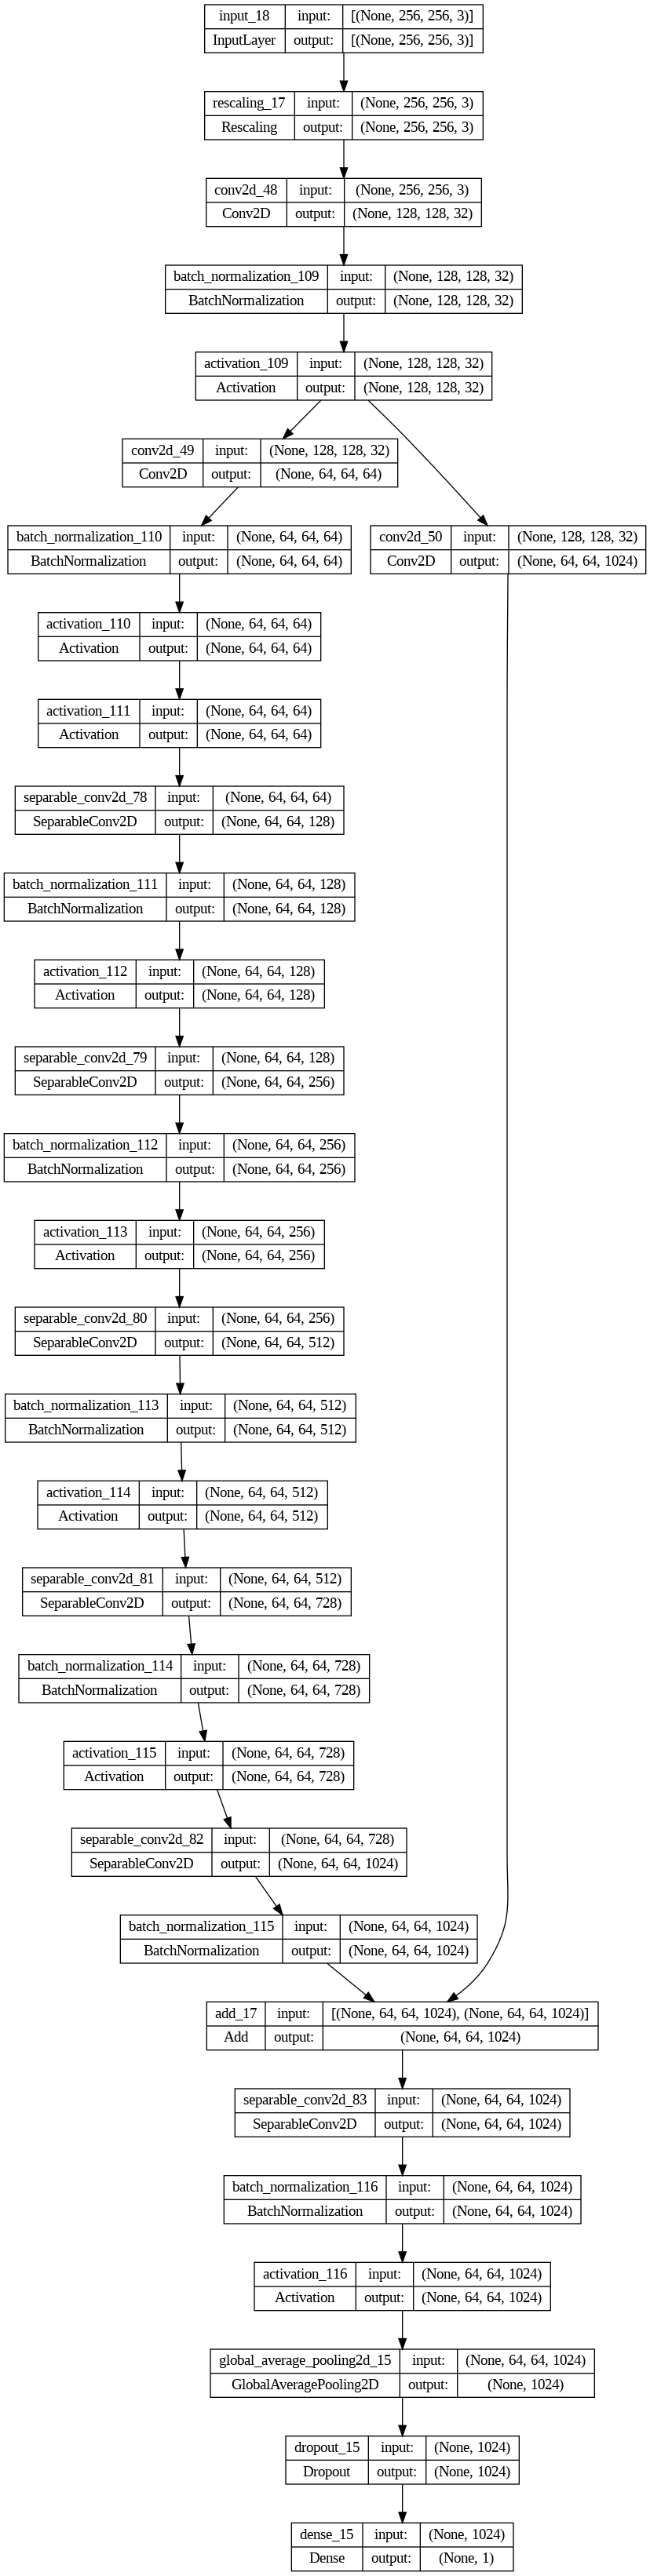

In [46]:
#CNN Model based on ref: https://keras.io/examples/vision/image_classification_from_scratch/ 


def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)

    x = layers.Conv2D(32, (3,3), strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("LeakyReLU")(x)

    previous_block_activation = x  # Set aside residual
    
    x = layers.Conv2D(64, (3,3), strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("LeakyReLU")(x)

    x = layers.Activation("LeakyReLU")(x)
    x = layers.SeparableConv2D(128, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Activation("LeakyReLU")(x)
    x = layers.SeparableConv2D(256, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation("LeakyReLU")(x)
    x = layers.SeparableConv2D(512, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Activation("LeakyReLU")(x)
    x = layers.SeparableConv2D(728, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation("LeakyReLU")(x)
    x = layers.SeparableConv2D(1024, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)


    # Project residual
    residual = layers.Conv2D(1024, (3,3), strides=2, padding="same")(
          previous_block_activation
      ) 
    x = layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("LeakyReLU")(x)

    x = layers.GlobalAveragePooling2D()(x)
    activation = "sigmoid"
    units = 1

    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)
model = make_model(input_shape=(image_size) + (3,), num_classes=1)
keras.utils.plot_model(model, show_shapes=True)


Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_17 (Rescaling)       (None, 256, 256, 3)  0           ['input_18[0][0]']               
                                                                                                  
 conv2d_48 (Conv2D)             (None, 128, 128, 32  896         ['rescaling_17[0][0]']           
                                )                                                                 
                                                                                           

1/1 [==============================] - 17s 17s/step - loss: 0.0000e+00 - acc: 0.0000e+00 - val_loss: 0.7401 - val_acc: 0.5472
dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


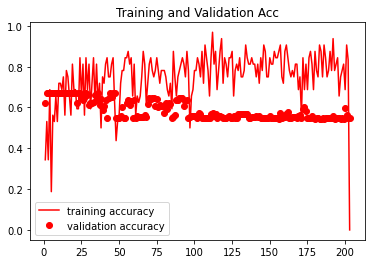

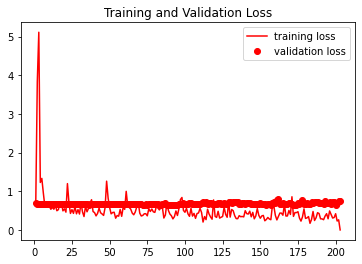

In [47]:
epochs = 502

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.001,momentum=0.001),
    loss="binary_crossentropy",
    metrics=["acc"],
) 
model.summary()
history = model.fit(
    train_ds,
    epochs=epochs,
    steps_per_epoch=1,
    callbacks=callbacks,
    validation_data=val_ds)
model.save('content/gdrive/My Drive/CNN_Models_Baseline/Extensive_COVID19_CT_model.h5')

print(history.history.keys())

accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy,'r',label = 'training accuracy')
plt.plot(epochs, val_accuracy,'ro',label = 'validation accuracy')
plt.title('Training and Validation Acc')
plt.legend()
plt.show()

plt.plot(epochs, train_loss,'r',label = 'training loss')
plt.plot(epochs, val_loss,'ro',label = 'validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
     


# X-Ray CNNS

In [69]:
#Loading of images based on ref: https://keras.io/examples/vision/image_classification_from_scratch/ 

image_size = (256, 256)
batch_size = 32
train_ds = tf.keras.utils.image_dataset_from_directory(extensive_COVID_database_X_Ray, validation_split=0.1,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    crop_to_aspect_ratio=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(extensive_COVID_database_X_Ray, validation_split=0.1,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    crop_to_aspect_ratio=True
)

Found 9537 files belonging to 2 classes.
Using 8584 files for training.
Found 9537 files belonging to 2 classes.
Using 953 files for validation.


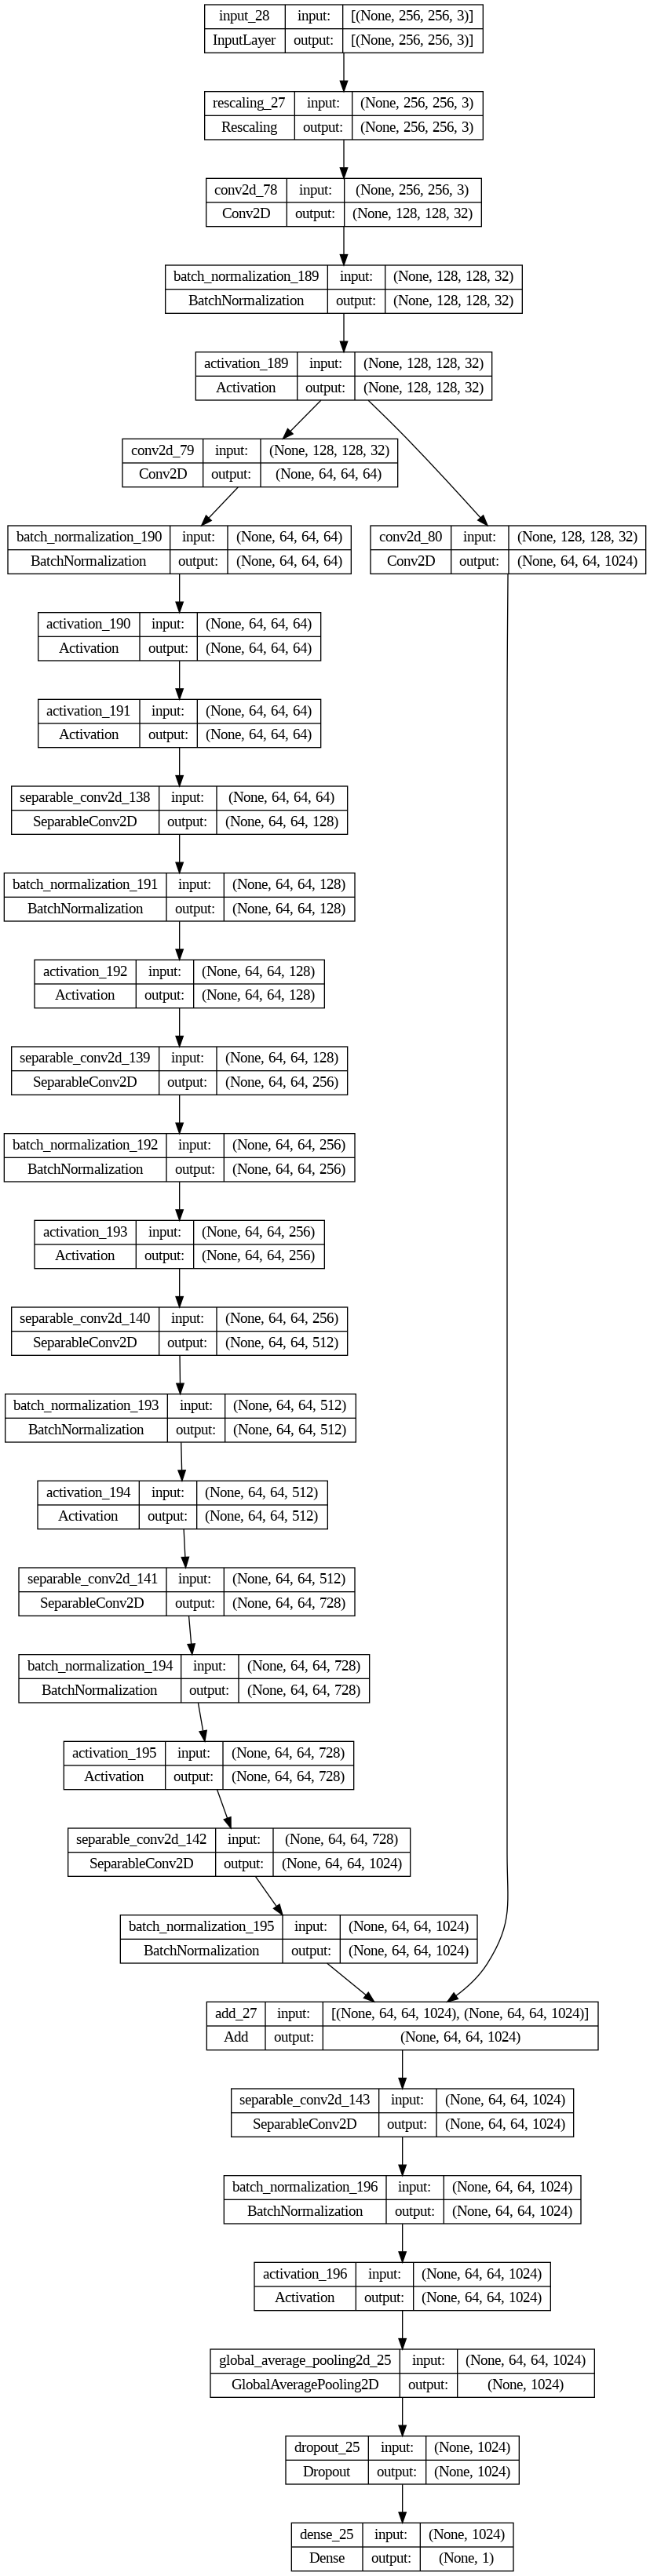

In [76]:
#CNN Model based on ref: https://keras.io/examples/vision/image_classification_from_scratch/ 


def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)

    x = layers.Conv2D(32, (3,3), strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("LeakyReLU")(x)

    previous_block_activation = x  # Set aside residual
    
    x = layers.Conv2D(64, (3,3), strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("LeakyReLU")(x)

    x = layers.Activation("LeakyReLU")(x)
    x = layers.SeparableConv2D(128, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Activation("LeakyReLU")(x)
    x = layers.SeparableConv2D(256, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation("LeakyReLU")(x)
    x = layers.SeparableConv2D(512, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Activation("LeakyReLU")(x)
    x = layers.SeparableConv2D(728, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation("LeakyReLU")(x)
    x = layers.SeparableConv2D(1024, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)


    # Project residual
    residual = layers.Conv2D(1024, (3,3), strides=2, padding="same")(
          previous_block_activation
      ) 
    x = layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("LeakyReLU")(x)

    x = layers.GlobalAveragePooling2D()(x)
    activation = "sigmoid"
    units = 1

    x = layers.Dropout(0)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)
model = make_model(input_shape=(image_size) + (3,), num_classes=1)
keras.utils.plot_model(model, show_shapes=True)


Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_28 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_27 (Rescaling)       (None, 256, 256, 3)  0           ['input_28[0][0]']               
                                                                                                  
 conv2d_78 (Conv2D)             (None, 128, 128, 32  896         ['rescaling_27[0][0]']           
                                )                                                                 
                                                                                           

1/1 [==============================] - 11s 11s/step - loss: 0.0000e+00 - acc: 0.0000e+00 - val_loss: 1.2028 - val_acc: 0.4512
dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


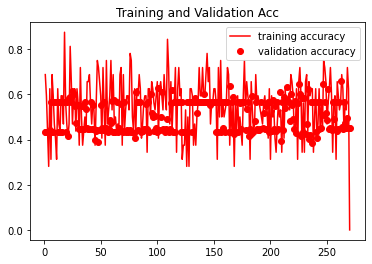

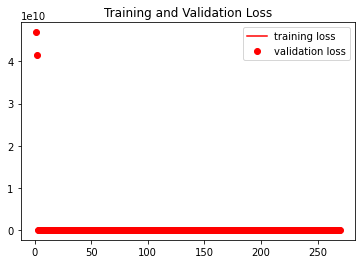

In [77]:
epochs = 298

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.1,momentum=0.1),
    loss="binary_crossentropy",
    metrics=["acc"],
) 
model.summary()
history = model.fit(
    train_ds,
    epochs=epochs,
    steps_per_epoch=1,
    callbacks=callbacks,
    validation_data=val_ds)
model.save('content/gdrive/My Drive/CNN_Models_Baseline/Extensive_COVID19_XRAY_model.h5')

print(history.history.keys())

accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy,'r',label = 'training accuracy')
plt.plot(epochs, val_accuracy,'ro',label = 'validation accuracy')
plt.title('Training and Validation Acc')
plt.legend()
plt.show()

plt.plot(epochs, train_loss,'r',label = 'training loss')
plt.plot(epochs, val_loss,'ro',label = 'validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
     
